In [8]:
from typing import Optional, Tuple

import torch
import math
from torch.testing import assert_close


def scaled_dot_product_attention(
    query: torch.Tensor,  # shape: (batch_size, num_heads, seq_len_q, depth)
    key: torch.Tensor,  # shape: (batch_size, num_heads, seq_len_k, depth)
    value: torch.Tensor,  # shape: (batch_size, num_heads, seq_len_v, depth)
    mask: Optional[
        torch.Tensor
    ] = None,  # shape: (batch_size, num_heads, seq_len_q, seq_len_k)
) -> Tuple[torch.Tensor, torch.Tensor]:
    """
    Compute scaled dot-product attention with optional masking.

    Args:
        query: Query tensor
        key: Key tensor
        value: Value tensor
        mask: Optional mask tensor. Should contain 0s for valid positions and 1s for masked positions.
            Will be converted to -inf for masked positions before softmax.

    Returns:
        tuple: (
            output tensor with shape (batch_size, num_heads, seq_len_q, depth),
            attention weights with shape (batch_size, num_heads, seq_len_q, seq_len_k)
        )

    Example:
        >>> q = torch.randn(2, 3, 4, 8)  # batch=2, heads=3, seq_len=4, depth=8
        >>> k = torch.randn(2, 3, 4, 8)
        >>> v = torch.randn(2, 3, 4, 8)
        >>> mask = torch.triu(torch.ones(4, 4), diagonal=1).bool()  # causal mask
        >>> mask = mask.expand(2, 3, 4, 4)  # expand to match batch and heads
        >>> output, attention = scaled_dot_product_attention(q, k, v, mask)
        >>> print(output.shape)  # (2, 3, 4, 8)
        >>> print(attention.shape)  # (2, 3, 4, 4)


    """

    dk = query.size(-1)

    scores = torch.matmul(query, key.transpose(-2, -1))


    scores = scores / math.sqrt(dk)


    if mask is not None:
        mask = mask.bool()
        scores = scores.masked_fill(mask, float('-inf'))


    attention_weights = torch.softmax(scores, dim=-1)

    output = torch.matmul(attention_weights, value)

    return output, attention_weights


    # Your implementation here
    # 1. Scale the attention scores by $\sqrt{d_k}$
    # 2. Apply the mask (if provided) before softmax
    # 3. Implement the attention computation efficiently using matrix operations
    # 4. Return both the output and attention weights

    pass


def test_basic_attention():
    batch_size, num_heads, seq_len, depth = 2, 3, 4, 8
    query = torch.randn(batch_size, num_heads, seq_len, depth)
    key = torch.randn(batch_size, num_heads, seq_len, depth)
    value = torch.randn(batch_size, num_heads, seq_len, depth)

    # Custom implementation
    custom_output, custom_weights = scaled_dot_product_attention(query, key, value)

    # PyTorch implementation (flip mask convention not needed as no mask used)
    torch_output = torch.nn.functional.scaled_dot_product_attention(query, key, value)

    # Assert outputs are close
    assert_close(custom_output, torch_output)
    assert custom_output.shape == (batch_size, num_heads, seq_len, depth)
    assert custom_weights.shape == (batch_size, num_heads, seq_len, seq_len)


def test_padding_mask():
    batch_size, num_heads, seq_len, depth = 2, 3, 4, 8
    query = torch.randn(batch_size, num_heads, seq_len, depth)
    key = torch.randn(batch_size, num_heads, seq_len, depth)
    value = torch.randn(batch_size, num_heads, seq_len, depth)

    # Create padding mask (1s for padded positions)
    padding_mask = torch.zeros(batch_size, num_heads, seq_len, seq_len)
    padding_mask[..., -1:] = 1  # Mask last position

    # Custom implementation
    custom_output, custom_weights = scaled_dot_product_attention(
        query, key, value, padding_mask
    )

    # PyTorch implementation (flip mask: True means attend, False means mask)
    torch_mask = ~padding_mask.bool()  # Flip mask convention
    torch_output = torch.nn.functional.scaled_dot_product_attention(
        query, key, value, attn_mask=torch_mask
    )

    assert_close(custom_output, torch_output)


def test_causal_mask():
    batch_size, num_heads, seq_len, depth = 2, 3, 4, 8
    query = torch.randn(batch_size, num_heads, seq_len, depth)
    key = torch.randn(batch_size, num_heads, seq_len, depth)
    value = torch.randn(batch_size, num_heads, seq_len, depth)

    # Create causal mask (1s for future positions)
    causal_mask = torch.triu(torch.ones(seq_len, seq_len), diagonal=1)
    causal_mask = causal_mask.expand(batch_size, num_heads, seq_len, seq_len)

    # Custom implementation
    custom_output, custom_weights = scaled_dot_product_attention(
        query, key, value, causal_mask
    )

    # PyTorch implementation (flip mask: True means attend, False means mask)
    torch_mask = ~causal_mask.bool()  # Flip mask convention
    torch_output = torch.nn.functional.scaled_dot_product_attention(
        query, key, value, attn_mask=torch_mask
    )

    assert_close(custom_output, torch_output)


def test_combined_mask():
    batch_size, num_heads, seq_len, depth = 2, 3, 4, 8
    query = torch.randn(batch_size, num_heads, seq_len, depth)
    key = torch.randn(batch_size, num_heads, seq_len, depth)
    value = torch.randn(batch_size, num_heads, seq_len, depth)

    # Create causal mask
    causal_mask = torch.triu(torch.ones(seq_len, seq_len), diagonal=1)
    causal_mask = causal_mask.expand(batch_size, num_heads, seq_len, seq_len)

    # Create padding mask
    padding_mask = torch.zeros(batch_size, num_heads, seq_len, seq_len)
    padding_mask[..., -1:] = 1  # Mask last position

    # Combine masks (1 in either mask means position should be masked)
    combined_mask = torch.logical_or(causal_mask, padding_mask)

    # Custom implementation
    custom_output, custom_weights = scaled_dot_product_attention(
        query, key, value, combined_mask
    )

    # PyTorch implementation (flip mask: True means attend, False means mask)
    torch_mask = ~combined_mask.bool()  # Flip mask convention
    torch_output = torch.nn.functional.scaled_dot_product_attention(
        query, key, value, attn_mask=torch_mask
    )

    assert_close(custom_output, torch_output)


def test_edge_cases():
    # Test with sequence length of 1
    batch_size, num_heads, depth = 2, 3, 8
    seq_len = 1
    query = torch.randn(batch_size, num_heads, seq_len, depth)
    key = torch.randn(batch_size, num_heads, seq_len, depth)
    value = torch.randn(batch_size, num_heads, seq_len, depth)

    custom_output, custom_weights = scaled_dot_product_attention(query, key, value)
    torch_output = torch.nn.functional.scaled_dot_product_attention(query, key, value)

    assert_close(custom_output, torch_output)

    # Test with different key/value sequence length
    seq_len_q, seq_len_kv = 4, 6
    query = torch.randn(batch_size, num_heads, seq_len_q, depth)
    key = torch.randn(batch_size, num_heads, seq_len_kv, depth)
    value = torch.randn(batch_size, num_heads, seq_len_kv, depth)

    custom_output, custom_weights = scaled_dot_product_attention(query, key, value)
    torch_output = torch.nn.functional.scaled_dot_product_attention(query, key, value)

    assert_close(custom_output, torch_output)
    assert custom_output.shape == (batch_size, num_heads, seq_len_q, depth)
    assert custom_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_kv)


if __name__ == "__main__":
    test_basic_attention()
    test_padding_mask()
    test_causal_mask()
    test_combined_mask()
    test_edge_cases()

    print("All tests passed!")


All tests passed!


In [12]:
from typing import Optional

import torch
from torch.testing import assert_close


def gqa(
    x: torch.Tensor,  # shape: (batch_size, seq_len, dim)
    num_query_heads: int,  # number of query heads
    num_kv_heads: int,  # number of key-value groups
    head_dim: int,  # dimension of each head
    w_q: torch.Tensor,  # shape: (num_query_heads * head_dim, dim)
    w_k: torch.Tensor,  # shape: (num_kv_heads * head_dim, dim)
    w_v: torch.Tensor,  # shape: (num_kv_heads * head_dim, dim)
    w_o: torch.Tensor,  # shape: (dim, num_query_heads * head_dim)
    mask: Optional[torch.Tensor] = None,  # shape: (batch_size, seq_len, seq_len)
) -> torch.Tensor:  # shape: (batch_size, seq_len, dim)
    """
    Compute Grouped Query Attention.

    The mask, if provided, will be expanded to shape (batch_size, num_query_heads, seq_len, seq_len) to
        properly broadcast across attention heads.

    Returns:
        Output tensor of shape (batch_size, seq_len, dim)
    """

    batch_size, seq_len, dim = x.shape


    Q = torch.matmul(x, w_q.t())
    K = torch.matmul(x, w_k.t())
    V = torch.matmul(x, w_v.t())


    Q = Q.view(batch_size, seq_len, num_query_heads, head_dim).transpose(1, 2)

    K = K.view(batch_size, seq_len, num_kv_heads, head_dim).transpose(1, 2)
    V = V.view(batch_size, seq_len, num_kv_heads, head_dim).transpose(1, 2)


    repeats = num_query_heads // num_kv_heads
    K = K.repeat_interleave(repeats, dim=1)
    V = V.repeat_interleave(repeats, dim=1)


    if mask is not None:
        mask = mask.unsqueeze(1).expand(batch_size, num_query_heads, seq_len, seq_len)


    output, attention_weights = scaled_dot_product_attention(Q, K, V, mask)

    output = output.transpose(1, 2).reshape(batch_size, seq_len, num_query_heads * head_dim)

    output = torch.matmul(output, w_o.t())

    # Your implementation here
    # 1. Project input to queries, keys, and values using provided weight matrices
    # 2. Reshape projections to separate heads
    # 3. Repeat keys and values for each query group
    # 4. Apply scaled dot-product attention
    # 5. Reshape and project output

    return output


def test_gqa():
    # Test Case 1: Basic functionality
    batch_size = 2
    seq_len = 4
    dim = 6
    num_query_heads = 4
    num_kv_heads = 2
    head_dim = 3

    # Create input and weights
    x = torch.randn(batch_size, seq_len, dim)
    w_q = torch.randn(num_query_heads * head_dim, dim)
    w_k = torch.randn(num_kv_heads * head_dim, dim)
    w_v = torch.randn(num_kv_heads * head_dim, dim)
    w_o = torch.randn(dim, num_query_heads * head_dim)

    output = gqa(x, num_query_heads, num_kv_heads, head_dim, w_q, w_k, w_v, w_o)
    assert output.shape == (batch_size, seq_len, dim)

    # Test Case 2: With masking
    mask = torch.zeros(batch_size, seq_len, seq_len)
    mask[:, -1, :] = 1  # Mask last position
    output_masked = gqa(
        x, num_query_heads, num_kv_heads, head_dim, w_q, w_k, w_v, w_o, mask
    )
    assert output_masked.shape == (batch_size, seq_len, dim)

    # Test Case 3: Compare with reference implementation
    x, w_q, w_k, w_v, w_o, num_query_heads, num_kv_heads, head_dim = torch.load(
        "gqa_input.pt"
    )
    output = gqa(x, num_query_heads, num_kv_heads, head_dim, w_q, w_k, w_v, w_o)

    # Load reference output
    reference = torch.load("gqa_ref_output.pt")
    assert_close(output, reference, rtol=1e-4, atol=1e-4)


if __name__ == "__main__":
    test_gqa()
    print("All tests passed!")


All tests passed!


<ipython-input-12-ed50747f29c5>:95: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  x, w_q, w_k, w_v, w_o, num_query_heads, num_kv_heads, head_dim = torch.load(
<ipython-input

In [13]:
from typing import Tuple

import torch
from torch.testing import assert_close


def precompute_rope_frequencies(
    dim: int,  # dimension of the embeddings (must be even)
    seq_len: int,  # maximum sequence length
    base: float = 10000.0,  # base for frequency computation
    dtype: torch.dtype = torch.float32,
) -> Tuple[torch.Tensor, torch.Tensor]:
    """
    Precompute the frequency table for rotary embeddings.

    Args:
        dim: Embedding dimension (must be even)
        seq_len: Maximum sequence length
        base: Base for frequency computation
        dtype: Tensor dtype

    Returns:
        Tuple[torch.Tensor, torch.Tensor]: Precomputed (cos, sin) tables
            each with shape (seq_len, dim/2)
    """
    half_dim = dim // 2

    inv_freq = 1.0 / (base ** (torch.arange(0, half_dim, dtype=dtype) / half_dim))


    positions = torch.arange(seq_len, dtype=dtype)
    angles = positions.unsqueeze(1) * inv_freq.unsqueeze(0)

    cos_table = torch.cos(angles)
    sin_table = torch.sin(angles)

    return cos_table, sin_table


def apply_rotary_embedding(
    x: torch.Tensor,  # shape: (batch_size, seq_len, num_heads, head_dim)
    cos: torch.Tensor,  # shape: (seq_len, head_dim/2)
    sin: torch.Tensor,  # shape: (seq_len, head_dim/2)
) -> torch.Tensor:
    """
    Apply rotary embeddings to input tensor using precomputed cosine and sine values.

    Args:
        x: Input tensor to be rotated
        cos: Precomputed cosine values for each position and dimension pair
        sin: Precomputed sine values for each position and dimension pair

    Returns:
        torch.Tensor: Rotated tensor of same shape as input

    Note:
        - head_dim must be even
        - rotation is applied pair-wise to dimensions [0,1], [2,3], etc.
    """
    batch_size, seq_len, num_heads, head_dim = x.shape

    half_dim = head_dim // 2
    x = x.view(batch_size, seq_len, num_heads, half_dim, 2)


    cos = cos.unsqueeze(0).unsqueeze(2)
    sin = sin.unsqueeze(0).unsqueeze(2)


    x0 = x[..., 0]
    x1 = x[..., 1]


    rotated_x0 = x0 * cos - x1 * sin
    rotated_x1 = x0 * sin + x1 * cos


    x_rotated = torch.stack([rotated_x0, rotated_x1], dim=-1)
    x_rotated = x_rotated.view(batch_size, seq_len, num_heads, head_dim)

    return x_rotated



def test_rope_frequencies():
    """Test the precomputation of RoPE frequency tables."""
    # Test Case 1: Basic frequency computation
    dim = 8
    seq_len = 4
    cos, sin = precompute_rope_frequencies(dim, seq_len)

    assert cos.shape == (seq_len, dim // 2)
    assert sin.shape == (seq_len, dim // 2)

    # Test Case 2: Verify frequency pattern
    dim = 4
    seq_len = 2
    cos, sin = precompute_rope_frequencies(dim, seq_len, base=10000.0)

    # Verify the geometric progression of frequencies
    freqs = 1.0 / (10000.0 ** (torch.arange(0, dim, 2).float() / dim))
    positions = torch.arange(seq_len).float()

    expected_cos = torch.cos(positions.unsqueeze(1) * freqs)
    expected_sin = torch.sin(positions.unsqueeze(1) * freqs)

    assert_close(cos, expected_cos, rtol=1e-6, atol=1e-6)
    assert_close(sin, expected_sin, rtol=1e-6, atol=1e-6)


def test_rotary_embedding():
    """Test the application of rotary embeddings."""
    batch_size = 2
    seq_len = 4
    num_heads = 3
    head_dim = 8

    # Test Case 1: Basic rotation
    x = torch.randn(batch_size, seq_len, num_heads, head_dim)
    cos, sin = precompute_rope_frequencies(head_dim, seq_len)

    rotated = apply_rotary_embedding(x, cos, sin)
    assert rotated.shape == x.shape

    # Test Case 2: Verify rotation for single vector
    # Create a simple 2D vector for testing
    x_simple = torch.tensor([1.0, 0.0]).view(1, 1, 1, 2)
    cos_simple = torch.tensor([[0.5]])  # cos(60°)
    sin_simple = torch.tensor([[0.866]])  # sin(60°)

    rotated_simple = apply_rotary_embedding(x_simple, cos_simple, sin_simple)
    expected_simple = torch.tensor([0.5, 0.866]).view(1, 1, 1, 2)
    assert_close(rotated_simple, expected_simple, rtol=1e-3, atol=1e-3)

    # Test Case 3: Translation invariance
    # Create a single vector and repeat it for three positions
    x_single = torch.randn(1, 1, 1, 2)  # A single 2D vector
    # Expand to three positions so that every position has the same vector
    x = x_single.expand(1, 3, 1, 2)

    # Precompute frequencies for 3 positions
    cos, sin = precompute_rope_frequencies(2, 3)

    # Apply RoPE to all positions
    rotated = apply_rotary_embedding(x, cos, sin)

    # For any fixed vector v, the dot product v · (R(δ)v) equals ||v||^2 * cos(δ)
    # With head_dim=2, our frequency for the only pair is 1 (since theta = 1 / (base^(0/2)) = 1)
    # So the dot product between positions 0 and 1, and between positions 1 and 2, should both equal ||v||^2 * cos(1)
    dot0_1 = (rotated[:, 0] * rotated[:, 1]).sum()
    dot1_2 = (rotated[:, 1] * rotated[:, 2]).sum()

    # They should be equal because the relative rotation is the same
    assert_close(dot0_1, dot1_2, rtol=1e-6, atol=1e-6)


if __name__ == "__main__":
    test_rope_frequencies()
    test_rotary_embedding()
    print("All tests passed!")


All tests passed!


In [1]:
!pip install torch transformers datasets nltk

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 65.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 50.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 35.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 77.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.4/485.4 kB 28.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
# load GPT2, add special tokens, and resize token embeddings

import torch
from transformers import AutoTokenizer, AutoModelForCausalLM

# Load GPT2 model and tokenizer
model_name = "gpt2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name)

# Add special tokens
special_tokens = {'additional_special_tokens': ['<len>', '<text>']}
tokenizer.add_special_tokens(special_tokens)

# Resize model embeddings
model.resize_token_embeddings(len(tokenizer))

# Set padding token since GPT2 doesn't have one
tokenizer.pad_token = tokenizer.eos_token

print(f"New vocabulary size: {len(tokenizer)}")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`


New vocabulary size: 50259


In [ ]:
# modify dataset to include length token

from datasets import load_dataset
import random

# Load dataset
dataset = load_dataset("Bingsu/openwebtext_20p", split="train")

# Select random subset
sample_percentage = 0.0002  # 0.02%
num_samples = int(len(dataset) * sample_percentage)
dataset_subset = dataset.select(random.sample(range(len(dataset)), num_samples))

print(f"Selected {len(dataset_subset)} training examples.")

README.md:   0%|          | 0.00/644 [00:00<?, ?B/s]

Resolving data files:   0%|          | 0/17 [00:00<?, ?it/s]

dataset_infos.json:   0%|          | 0.00/904 [00:00<?, ?B/s]

(…)-00000-of-00017-0e705cf331ed18de.parquet:   0%|          | 0.00/292M [00:00<?, ?B/s]

(…)-00001-of-00017-a4ce76e3af4a10a2.parquet:   0%|          | 0.00/292M [00:00<?, ?B/s]

(…)-00002-of-00017-8080624fb5bd62a5.parquet:   0%|          | 0.00/289M [00:00<?, ?B/s]

(…)-00003-of-00017-6363b062d4ffc269.parquet:   0%|          | 0.00/290M [00:00<?, ?B/s]

(…)-00004-of-00017-7cd802bc44267552.parquet:   0%|          | 0.00/292M [00:00<?, ?B/s]

(…)-00005-of-00017-c24edb897aad6b63.parquet:   0%|          | 0.00/290M [00:00<?, ?B/s]

(…)-00006-of-00017-256383ed4f5ceb06.parquet:   0%|          | 0.00/289M [00:00<?, ?B/s]

(…)-00007-of-00017-ad6d5320cd779f29.parquet:   0%|          | 0.00/291M [00:00<?, ?B/s]

(…)-00008-of-00017-c4dfa6363bfc863c.parquet:   0%|          | 0.00/291M [00:00<?, ?B/s]

(…)-00009-of-00017-f0d89563b3606a75.parquet:   0%|          | 0.00/290M [00:00<?, ?B/s]

(…)-00010-of-00017-a8301f271b59a7c6.parquet:   0%|          | 0.00/291M [00:00<?, ?B/s]

(…)-00011-of-00017-abfc5e9dfc6bb910.parquet:   0%|          | 0.00/291M [00:00<?, ?B/s]

(…)-00012-of-00017-a01d4e3d3dc94d8b.parquet:   0%|          | 0.00/292M [00:00<?, ?B/s]

(…)-00013-of-00017-1262b87d6290a71e.parquet:   0%|          | 0.00/292M [00:00<?, ?B/s]

(…)-00014-of-00017-e08331b236d6ea20.parquet:   0%|          | 0.00/292M [00:00<?, ?B/s]

(…)-00015-of-00017-d88f6095d9439e35.parquet:   0%|          | 0.00/290M [00:00<?, ?B/s]

(…)-00016-of-00017-55bc94e70d1f8efa.parquet:   0%|          | 0.00/290M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/33167823 [00:00<?, ? examples/s]

Loading dataset shards:   0%|          | 0/17 [00:00<?, ?it/s]

Selected 6633 training examples.


In [ ]:
# format data (count words and prepend to sentences)

import nltk
nltk.download('punkt_tab')
from nltk.tokenize import word_tokenize



def format_example(example):
    text = example['text']
    word_count = len(word_tokenize(text))  # Count words
    return {"text": f"<len> {word_count} <text> {text}"}

# Apply transformation
dataset_transformed = dataset_subset.map(format_example)

# Print example
print(dataset_transformed[0]['text'])

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


Map:   0%|          | 0/6633 [00:00<?, ? examples/s]

<len> 75 <text> We must not be naive, of course: there have been – and continue to be – disciples of covert Treaty change by stealth. Examples of this are the “Spitzenkandidat” method of nominating the President of the Commission, or the Commission’s proposals on the permanent and mandatory redistribution of refugees. But I could also cite the European Parliament’s latest decision on triggering Article 50.


In [ ]:
# convert text to tokenized inputs

def tokenize_function(example):
    encoding = tokenizer(example['text'], truncation=True, padding="max_length", max_length=128)
    encoding["labels"] = encoding["input_ids"].copy()  # Labels must be the same as input_ids
    return encoding

dataset_tokenized = dataset_transformed.map(tokenize_function, batched=True)
dataset_tokenized.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])

Map:   0%|          | 0/6633 [00:00<?, ? examples/s]

In [ ]:
# fine-tune GPT2 w/ gradient accumulation

from torch.utils.data import DataLoader
from transformers import Trainer, TrainingArguments

# Create DataLoader
batch_size = 8
train_dataloader = DataLoader(dataset_tokenized, batch_size=batch_size, shuffle=True)

# Define training arguments
training_args = TrainingArguments(
    output_dir="./gpt2_length_control",
    per_device_train_batch_size=batch_size,
    gradient_accumulation_steps=2,  # Accumulate gradients before updating
    learning_rate=3e-5,
    max_steps=5000,
    logging_steps=500,  # Log loss every 500 steps
    num_train_epochs=2,  # Adjust as needed
    logging_dir="./logs",
    save_strategy="epoch",
    report_to="none",  # Disable W&B logging
    fp16=True
)

# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset_tokenized,
)

# Start training
trainer.train()

Step,Training Loss


In [ ]:
# prompt for controlled text generation

def generate_text(target_length):
    prompt = f"<len> {target_length} <text>"
    input_ids = tokenizer(prompt, return_tensors="pt").input_ids

    # Generate text
    output = model.generate(
        input_ids,
        max_length=target_length,
        num_return_sequences=1,
        do_sample=True,
        temperature=0.7
    )

    # Decode output
    return tokenizer.decode(output[0])

# Test different lengths
for length in [5, 10, 15, 20, 25, 30]:
    print(f"\nTarget Length: {length}")
    print(generate_text(length))

In [ ]:
# evaluate performance

def compute_length_error(generated_texts, target_lengths):
    errors = []
    for text, target_length in zip(generated_texts, target_lengths):
        actual_length = len(word_tokenize(text))
        errors.append(abs(target_length - actual_length))
    return sum(errors) / len(errors)

# Generate sample texts
generated_texts = [generate_text(length) for length in [5, 10, 15, 20, 25, 30]]

# Compute error
error = compute_length_error(generated_texts, [5, 10, 15, 20, 25, 30])
print(f"Average Length Control Error: {error}")

In [1]:
!pip install torch transformers datasets nltk

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 79.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 83.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 52.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 35.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 16.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 79.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.4/485.4 kB 30.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
# load GPT2, add special tokens, and resize token embeddings

import torch
from transformers import AutoTokenizer, AutoModelForCausalLM

# Load GPT2 model and tokenizer
model_name = "gpt2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name)

# Add special tokens
special_tokens = {'additional_special_tokens': ['<reading_level>', '<text>']}
tokenizer.add_special_tokens(special_tokens)

# Resize model embeddings
model.resize_token_embeddings(len(tokenizer))

# Set padding token since GPT2 doesn't have one
tokenizer.pad_token = tokenizer.eos_token

print(f"New vocabulary size: {len(tokenizer)}")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`


New vocabulary size: 50259


In [3]:
# modify dataset to include length token

from datasets import load_dataset
import random

# Load dataset
dataset = load_dataset("Bingsu/openwebtext_20p", split="train")

# Select random subset
sample_percentage = 0.0002  # 0.02%
num_samples = int(len(dataset) * sample_percentage)
dataset_subset = dataset.select(random.sample(range(len(dataset)), num_samples))

print(f"Selected {len(dataset_subset)} training examples.")

README.md:   0%|          | 0.00/644 [00:00<?, ?B/s]

Resolving data files:   0%|          | 0/17 [00:00<?, ?it/s]

dataset_infos.json:   0%|          | 0.00/904 [00:00<?, ?B/s]

(…)-00000-of-00017-0e705cf331ed18de.parquet:   0%|          | 0.00/292M [00:00<?, ?B/s]

(…)-00001-of-00017-a4ce76e3af4a10a2.parquet:   0%|          | 0.00/292M [00:00<?, ?B/s]

(…)-00002-of-00017-8080624fb5bd62a5.parquet:   0%|          | 0.00/289M [00:00<?, ?B/s]

(…)-00003-of-00017-6363b062d4ffc269.parquet:   0%|          | 0.00/290M [00:00<?, ?B/s]

(…)-00004-of-00017-7cd802bc44267552.parquet:   0%|          | 0.00/292M [00:00<?, ?B/s]

(…)-00005-of-00017-c24edb897aad6b63.parquet:   0%|          | 0.00/290M [00:00<?, ?B/s]

(…)-00006-of-00017-256383ed4f5ceb06.parquet:   0%|          | 0.00/289M [00:00<?, ?B/s]

(…)-00007-of-00017-ad6d5320cd779f29.parquet:   0%|          | 0.00/291M [00:00<?, ?B/s]

(…)-00008-of-00017-c4dfa6363bfc863c.parquet:   0%|          | 0.00/291M [00:00<?, ?B/s]

(…)-00009-of-00017-f0d89563b3606a75.parquet:   0%|          | 0.00/290M [00:00<?, ?B/s]

(…)-00010-of-00017-a8301f271b59a7c6.parquet:   0%|          | 0.00/291M [00:00<?, ?B/s]

(…)-00011-of-00017-abfc5e9dfc6bb910.parquet:   0%|          | 0.00/291M [00:00<?, ?B/s]

(…)-00012-of-00017-a01d4e3d3dc94d8b.parquet:   0%|          | 0.00/292M [00:00<?, ?B/s]

(…)-00013-of-00017-1262b87d6290a71e.parquet:   0%|          | 0.00/292M [00:00<?, ?B/s]

(…)-00014-of-00017-e08331b236d6ea20.parquet:   0%|          | 0.00/292M [00:00<?, ?B/s]

(…)-00015-of-00017-d88f6095d9439e35.parquet:   0%|          | 0.00/290M [00:00<?, ?B/s]

(…)-00016-of-00017-55bc94e70d1f8efa.parquet:   0%|          | 0.00/290M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/33167823 [00:00<?, ? examples/s]

Loading dataset shards:   0%|          | 0/17 [00:00<?, ?it/s]

Selected 6633 training examples.


In [4]:
!pip install textstat


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.3/105.3 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 939.4/939.4 kB 22.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 66.0 MB/s eta 0:00:00


In [6]:
# format data (count words and prepend to sentences)

import nltk
nltk.download('punkt_tab')
from nltk.tokenize import word_tokenize

import textstat

def format_example(example):
    text = example['text']
    reading_level = textstat.flesch_reading_ease(text)
    # word_count = len(word_tokenize(text))  # Count words
    return {"text": f"<reading_level> {reading_level} <text> {text}"}

# Apply transformation
dataset_transformed = dataset_subset.map(format_example)

# Print example
print(dataset_transformed[0]['text'])

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


Map:   0%|          | 0/6633 [00:00<?, ? examples/s]

<reading_level> 95.17 <text> I chase your lazy whalers home from the Disko floe;


In [38]:
# convert text to tokenized inputs

def tokenize_function(example):
    encoding = tokenizer(example['text'], truncation=True, padding="max_length", max_length=128)
    encoding["labels"] = encoding["input_ids"].copy()  # Labels must be the same as input_ids
    return encoding

dataset_tokenized = dataset_transformed.map(tokenize_function, batched=True)
dataset_tokenized.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])

Map:   0%|          | 0/6633 [00:00<?, ? examples/s]

In [39]:
# fine-tune GPT2 w/ gradient accumulation

from torch.utils.data import DataLoader
from transformers import Trainer, TrainingArguments

# Create DataLoader
batch_size = 8
train_dataloader = DataLoader(dataset_tokenized, batch_size=batch_size, shuffle=True)

# Define training arguments
training_args = TrainingArguments(
    output_dir="./gpt2_reading_level_control",
    per_device_train_batch_size=batch_size,
    gradient_accumulation_steps=2,  # Accumulate gradients before updating
    learning_rate=5e-5,
    max_steps=5000,
    logging_steps=500,  # Log loss every 500 steps
    num_train_epochs=2,  # Adjust as needed
    logging_dir="./logs",
    save_strategy="epoch",
    report_to="none",  # Disable W&B logging
    fp16=True
)

# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset_tokenized,
)

# Start training
trainer.train()

Step,Training Loss
500,0.483000
1000,0.448100
1500,0.413500
2000,0.390600
2500,0.366100
3000,0.342100
3500,0.329700
4000,0.319400
4500,0.307700
5000,0.301200


TrainOutput(global_step=5000, training_loss=0.37013349304199217, metrics={'train_runtime': 664.9315, 'train_samples_per_second': 120.313, 'train_steps_per_second': 7.52, 'total_flos': 1.22352035328e+16, 'train_loss': 0.37013349304199217, 'epoch': 12.048192771084338})

In [35]:
# prompt for controlled text generation

def generate_text(reading_level):
    prompt = f"<reading_level> {reading_level} <text>"
    #input_ids = tokenizer(prompt, return_tensors="pt").input_ids
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)


    # Generate text
    output = model.generate(
        input_ids=inputs.input_ids,
        max_length=300,
        num_return_sequences=1,
        do_sample=True,
        temperature=0.7,
        attention_mask=inputs.attention_mask,
        pad_token_id=tokenizer.eos_token_id
    )

    # Decode output
    return tokenizer.decode(output[0], skip_special_tokens=True)

# Test different lengths
for length in [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]:
    print(f"\nTarget Reading Level: {length}")
    print(generate_text(length))


Target Reading Level: 10
 10  The first of these would be a new way of generating electricity for the grid, similar to what has been used in Europe to generate electricity.

Target Reading Level: 20
 20  The latest data from the U.S. Census Bureau shows that the number of black-outed households has risen slightly over the past decade, from a high of 8.6 million in 2004 to a record high of 16.5 million in 2012. The number of black-outed households stood at 4.5 million in 2012, up from 3.7 million in 2004.

Target Reading Level: 30
 30  The mayor's office says it will file a lawsuit in Superior Court in San Francisco on Monday, April 4. The suit alleges that the mayor's office withheld certain documents related to the investigation and the bidding process for the $43 million project from the City of San Francisco. The suit names Mayor Ed Lee and City Council members Kevin de León and Councilwoman Deb Byers.

Target Reading Level: 40
 40  I’ve had a few people tell me that with their pho

In [37]:
# evaluate performance

def compute_reading_level_error(generated_texts, target_level):
    errors = []
    for text, target_level in zip(generated_texts, target_level):
        actual_reading_level = textstat.flesch_reading_ease(text)
        errors.append(abs(actual_reading_level - target_level))
    return sum(errors) / len(errors)

# Generate sample texts
generated_texts = [generate_text(reading_level) for reading_level in [10, 20, 30, 40, 50, 60]]

# Compute error
error = compute_reading_level_error(generated_texts, [10, 20, 30, 40, 50, 60])
print(f"Average Reading Level Control Error: {error}")

Average Reading Level Control Error: 31.304999999999996


Average Flesch Reading Ease Score: 68.62468884059669
Average Word Length (characters): 5.324667872701041
Average Sentence Length (words): 15.63399055463289


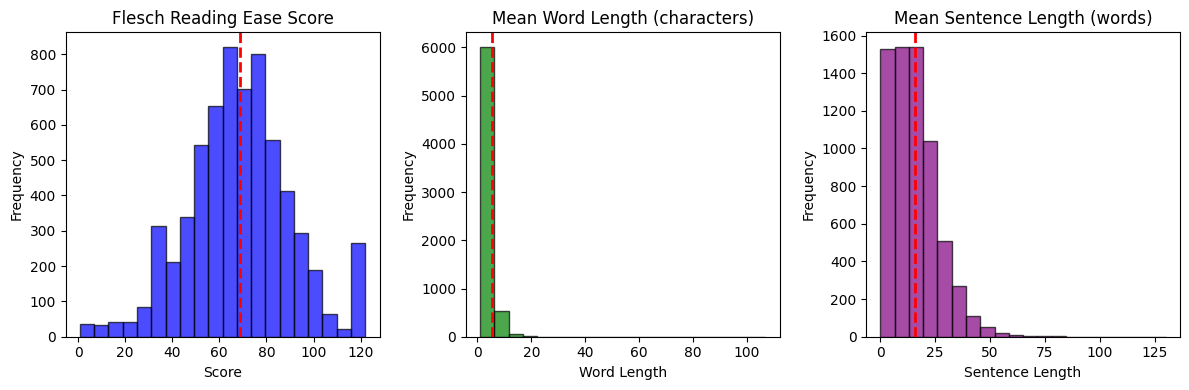

In [54]:
import re
import matplotlib.pyplot as plt

# Function to count syllables in a word
def count_syllables(word):
    if not word:  # Handle empty or None words
        return 1
    word = word.lower()
    vowels = "aeiouy"
    count = 0
    prev_char = ""

    for char in word:

          if char in vowels and prev_char not in vowels:
              count += 1
          prev_char = char

    # Adjustments for words ending in 'e'
    if word.endswith("e") and count > 1:
        count -= 1

    return max(1, count)  # Ensure at least one syllable per word

# Function to calculate Flesch Reading Ease score
def flesch_reading_ease(text):
    if not text or not isinstance(text, str):  # Handle None or non-string text
        return 0

    sentences = max(1, len(re.split(r'[.!?]', text)))  # Count sentences
    words = text.split()
    num_words = len(words)
    syllables = sum(count_syllables(word) for word in words)  # Count syllables

    # Avoid division by zero
    if num_words == 0:
        return 0

    # Calculate Flesch Reading Ease score
    flesch_score = 206.835 - (1.015 * (num_words / sentences)) - (84.6 * (syllables / num_words))
    return flesch_score

# Function to calculate mean word length (characters) and mean sentence length (words)
def calculate_text_statistics(text):
    if not text or not isinstance(text, str):  # Handle None or non-string text
        return 0, 0

    sentences = re.split(r'[.!?]', text)
    sentences = [s.strip() for s in sentences if s.strip()]  # Remove empty sentences
    words = text.split()

    num_words = len(words)
    num_sentences = len(sentences) if sentences else 1
    num_chars = sum(len(word) for word in words)

    mean_word_length = num_chars / num_words if num_words else 0
    mean_sentence_length = num_words / num_sentences if num_sentences else 0

    return mean_word_length, mean_sentence_length

# Compute statistics for dataset subset
flesch_scores = []
mean_word_lengths = []
mean_sentence_lengths = []

for example in dataset_subset:
    text = example.get("text", None)  # Use .get() to avoid KeyError
    flesch_scores.append(flesch_reading_ease(text))
    word_length, sentence_length = calculate_text_statistics(text)
    mean_word_lengths.append(word_length)
    mean_sentence_lengths.append(sentence_length)

# Remove invalid (zero) values to avoid distorting the results
flesch_scores = [s for s in flesch_scores if s > 0]
mean_word_lengths = [w for w in mean_word_lengths if w > 0]
mean_sentence_lengths = [s for s in mean_sentence_lengths if s > 0]

# Calculate overall averages
average_flesch_score = sum(flesch_scores) / len(flesch_scores) if flesch_scores else 0
average_word_length = sum(mean_word_lengths) / len(mean_word_lengths) if mean_word_lengths else 0
average_sentence_length = sum(mean_sentence_lengths) / len(mean_sentence_lengths) if mean_sentence_lengths else 0

# Print results
print(f"Average Flesch Reading Ease Score: {average_flesch_score}")
print(f"Average Word Length (characters): {average_word_length}")
print(f"Average Sentence Length (words): {average_sentence_length}")

# Plot histograms
plt.figure(figsize=(12, 4))

# Flesch Reading Ease Score
plt.subplot(1, 3, 1)
plt.hist(flesch_scores, bins=20, color='blue', alpha=0.7, edgecolor='black')
plt.axvline(average_flesch_score, color='red', linestyle='dashed', linewidth=2)
plt.title("Flesch Reading Ease Score")
plt.xlabel("Score")
plt.ylabel("Frequency")

# Mean Word Length
plt.subplot(1, 3, 2)
plt.hist(mean_word_lengths, bins=20, color='green', alpha=0.7, edgecolor='black')
plt.axvline(average_word_length, color='red', linestyle='dashed', linewidth=2)
plt.title("Mean Word Length (characters)")
plt.xlabel("Word Length")
plt.ylabel("Frequency")

# Mean Sentence Length
plt.subplot(1, 3, 3)
plt.hist(mean_sentence_lengths, bins=20, color='purple', alpha=0.7, edgecolor='black')
plt.axvline(average_sentence_length, color='red', linestyle='dashed', linewidth=2)
plt.title("Mean Sentence Length (words)")
plt.xlabel("Sentence Length")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()
